In [172]:
#Packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os, glob
from sklearn import preprocessing
from sklearn.decomposition import PCA

## Load and Manipulate Data

### Load the data

In [70]:
#Load the census data
census_dat = pd.read_csv('./data/Census_Data_Cleaned.csv', dtype = 'str')

#Load the hospital beds data
beds_dat = pd.read_csv('./data/hospital_beds_data.csv', dtype = 'str')

#Load the cases data
cases_nyc = pd.read_csv('./data/coronavirus-data/tests-by-zcta.csv', dtype = 'str')

### Combine and Manipulate the data

In [71]:
#Join all the values together
data = cases_nyc.merge(census_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip_code_tabulation_area')
data = data.merge(beds_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip')

data["beds"] = data["beds"].fillna(0)

In [72]:
#Remove the first record (no zip)
data = data[1:]

#Remove the zip code columns
data = data.loc[:, data.columns != 'zip_code_tabulation_area']
data = data.loc[:, data.columns != 'zip']

In [73]:
#Cast the rest of the columns as float
for col in data.columns:
    if col == "MODZCTA":
        continue 
    else:
        data.loc[:,col] = data.loc[:,col].astype(float)

In [74]:
data.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos,median_house_income,housing_units,pop_total,med_age,pop_perc_white,pop_perc_black,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
1,10001,288.0,685.0,42.04,86801.0,13305.0,23537.0,35.6,0.602456,0.121893,...,0.060729,0.005398,0.018893,0.020243,0.037787,0.191633,0.017544,0.018893,0.045884,0.0
2,10002,780.0,1603.0,48.66,33726.0,35691.0,80736.0,40.8,0.295605,0.086108,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0
3,10003,368.0,977.0,37.67,98151.0,31575.0,57112.0,32.1,0.776352,0.043599,...,0.050100,0.008016,0.022044,0.040080,0.088176,0.126253,0.036072,0.026052,0.052104,501.0
4,10004,26.0,75.0,34.67,119691.0,2082.0,3221.0,33.1,0.705992,0.007141,...,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.0
5,10005,48.0,156.0,30.77,124194.0,5254.0,8131.0,29.4,0.753413,0.029517,...,0.050412,0.004583,0.018332,0.032997,0.035747,0.156737,0.096242,0.039413,0.048579,0.0


### Handle Null Values

In [95]:
#Null values
data.isnull().sum(axis = 0).sort_values().tail(10)

med_monthlyhousingcost               3
med_numberrooms                      6
med_yearbuilt                        7
perc_hadbaby_pastyear_married        7
perc_hadbaby_pastyear_unmarried      7
med_value                           26
avg_hoursworked                     33
med_contractrent                    58
avg_income_deficit_pastyear        129
med_age_marriage                   177
dtype: int64

In [93]:
data[data.med_monthlyhousingcost.isnull()]

,MODZCTA,Positive,Total,zcta_cum.perc_pos,median_house_income,housing_units,pop_total,med_age,pop_perc_white,pop_perc_black,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
2,10002,780.0,1603.0,48.66,33726.0,35691.0,80736.0,40.8,0.295605,0.086108,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
147,11377,1627.0,2892.0,56.26,50436.0,33840.0,90615.0,36.7,0.478971,0.026673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
166,11428,547.0,936.0,58.44,67151.0,5929.0,19744.0,40.2,0.222194,0.184410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


None of the columns with very common nulls seem too critical. We will exclude the columns with more than 10 nulls and for those with less than 10 nulls we will impute the value using the average.

In [100]:
#Exclude columns with > 10 nulls
data = data.drop(['med_value','avg_hoursworked','med_contractrent',
                  'avg_income_deficit_pastyear','med_age_marriage'], axis = 1)

In [108]:
#Impute values for columsn with < 10 nulls
#data["beds"] = data["beds"].fillna(0)
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())

In [112]:
#Check we've removed them all:
data.isnull().sum(axis = 0).sort_values().tail() #0. good.

perc_transport_to_work_workathome    0
perc_transport_to_work_taxi          0
perc_transport_to_work_walk          0
perc_transport_to_work_public        0
beds                                 0
dtype: int64

In [151]:
#Percent Columns
cols = [col for col in data.columns if 'perc' in col]

for col in cols:
    data.loc[data[col] > 1, col] = 1

## Clustering Analysis

### Standardize the data

Standardize the Covariates

In [185]:
X = data.loc[:,"median_house_income":]

#Set the scaler
X = preprocessing.StandardScaler().fit_transform(X)

Standardize the outcome variable (disease burden)

In [188]:
y = np.array(data[["Positive"]]).reshape(-1)

In [193]:
cases_per_10k = (data.Positive / data.pop_total) * 10000

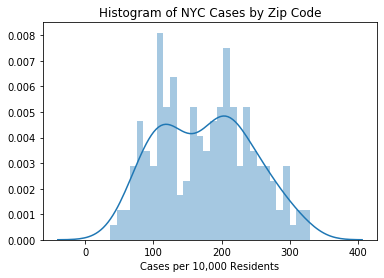

In [219]:
#Visualize the distribution of cases by zip
sns.distplot(cases_per_10k, bins = 30)
plt.title("Histogram of NYC Cases by Zip Code")
plt.xlabel("Cases per 10,000 Residents")
plt.show();

For the purposes of plotting, it may be helpful to bin the disease burden into categories: High, Medium, Low.

In [228]:
y_categorical = cases_per_10k

#Low
y_categorical[cases_per_10k < cases_per_10k.mean() - cases_per_10k.std()] = 0
#Medium
y_categorical[cases_per_10k >= cases_per_10k.mean() - cases_per_10k.std()] = 1
#High
y_categorical[cases_per_10k >= cases_per_10k.mean() + cases_per_10k.std()] = 2

### PCA and Visualization

The bimodal distribution certainly seems to indicate that not all of these cases are coming from the same distribution and there are underlying factors that are differentiating these observations.

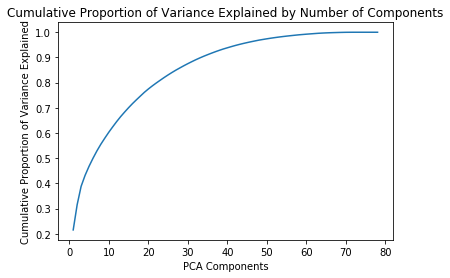

In [186]:
#Fit PCA
pca = PCA().fit(X)
X_pca = PCA().fit_transform(X)

#Plot Variance explained
plt.plot(list(range(1,79)), np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Proportion of Variance Explained by Number of Components")
plt.xlabel("PCA Components")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.show();

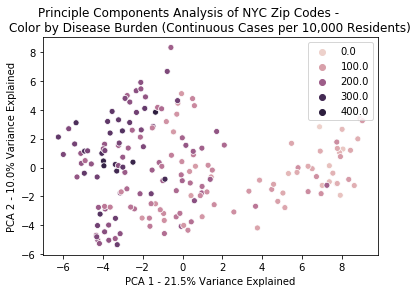

In [218]:
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = cases_per_10k)
plt.title("Principle Components Analysis of NYC Zip Codes - \
          \nColor by Disease Burden (Continuous Cases per 10,000 Residents)")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.show();

In [181]:
y

,Positive
1,288.0
2,780.0
3,368.0
4,26.0
5,48.0
...,...
173,1738.0
174,457.0
175,275.0
176,551.0
